In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

# Basic functionality on a graph

After importing a Raphtory graph we can create a blank one to work with:

* Graphs in Raphtory are directed by default


In [2]:
from raphtory import Graph
g = Graph()
g

Graph(number_of_edges=0, number_of_vertices=0, number_of_temporal_edges=0, earliest_time="None", latest_time="None")

In [3]:
g.add_edge(0, 1, 2)
g.add_edge(0, 1, 3, layer="layer1")
g.add_edge(0, 1, 4, layer="layer2")

g.vertices.edges.layer_names()


NestedStringVecIterable([[[_default], [layer1], [layer2]], [[_default]], [[layer1]], [[layer2]]])

Once we have a new graph we can add vertices and edges to it via `add_vertex()` and `add_edge()`. For these:
* The ids of vertices and the source/destination of an edge can be either strings or integers
* All additions into the graph must happen at a specific time - this means updates are also additions
* If you add an edge between vertices which do no exist in the graph yet, these will be automatically created
* Properties can be added onto vertices and edges - this is a dict of any value, but the keys must be strings
* We have a special type of `static property` which exists outside of the timeline and is always accessible. 
* Additions can be completed out of order, making it very easy to merge datasets together


We can then check the state of the graph:
* To see if a vertex or edge exists you can use `has_vertex()` and `has_edge()`
* To get the earliest and latest times at which updates have been applied to the graph you can use `earliest_time()` and `latest_time()` - if no updates have been applied these will return `None`
* To get the total number of vertices and edges of a graph you can use `num_edges()` and `num_vertices()`.

In [4]:
# Basic Addition with integer IDs
g.add_vertex(timestamp=1,id=10)
g.add_edge(timestamp=2,src=1,dst=2)

# checking vertex 10, 1 and 5 exist 
print(g.has_vertex(10), g.has_vertex(1), g.has_vertex(5))
# checking edge 1,2 exists and 2,1 doesn't as Raphtory is directed
print(g.has_edge(1,2),g.has_edge(2,1))
# Check the total number of edges and vertices
print(g.count_edges(),g.count_vertices())

# Adding vertices and edges with String IDs
g.add_vertex(timestamp=5,id="Ben")
g.add_edge(timestamp=8,src="Hamza",dst="Ben", layer="toad")

# Performing the same checks as before, but with strings
print(g.has_vertex(id="Ben"), g.has_vertex(id="Hamza"), g.has_vertex(id="Dave"))
print(g.has_edge(src="Hamza",dst="Ben"),g.has_edge(src="Ben",dst="Hamza"))
print(g.count_edges(),g.count_vertices())

g.add_edge(0, 1, 3, layer="toad")
#Add an edge with Temporal Properties which can change over time
e = g.add_edge(timestamp=7,src="Haaroon",dst="Hamza",properties={"property1": 1, "property2": 9.8, "property3": "test"}, layer="toad")
#Add a static property which is immutable
e.add_constant_properties(properties={"First-Met":"01/01/1990"})

#Add an vertex with Temporal Properties which can change over time
v = g.add_vertex(timestamp=5,id="Hamza",properties= {"property1": 5, "property2": 12.5, "property3": "test2"})
#Add a static property which is immutable
v.add_constant_properties(properties={"Date-of-Birth":"01/01/1990"})
print(g.vertex("Ben").__repr__())
print(g.edge("Haaroon","Hamza").__repr__())
print(g.__repr__())
with tempfile.NamedTemporaryFile() as g_path:
    g.save_to_file(g_path.name)

    loaded_graph = Graph.load_from_file(g_path.name)

    print(loaded_graph.has_vertex("Hamza"))

True True False
True False
3 5
True True False
True False
4 7
Vertex(name=Ben, earliest_time="5", latest_time="8", properties={_id: Ben})
Edge(source=Haaroon, target=Hamza, earliest_time=7, latest_time=7, properties={property2: 9.8, property3: test, property1: 1, First-Met: {"toad": Str("01/01/1990")}})
Graph(number_of_edges=5, number_of_vertices=8, number_of_temporal_edges=7, earliest_time="0", latest_time="8")
True


In [5]:
list(g.edges().layer_name())

[None, None, None, None, None]

In [6]:
g.vertices.edges.start()

NestedOptionI64Iterable([[0, 0, 0], [0], [0], [0], [], [0], [0, 0], [0]])

In [7]:
from raphtory import graph_loader

g = graph_loader.lotr_graph()
view = g.at(300)
g.add_vertex(timestamp=0,id="Gandalf",properties={"Race":"Maiar"})

#view["Gandalf"]["Race"]
from raphtory import export

export.to_networkx(view)

<Axes: xlabel='degree', ylabel='Count'>

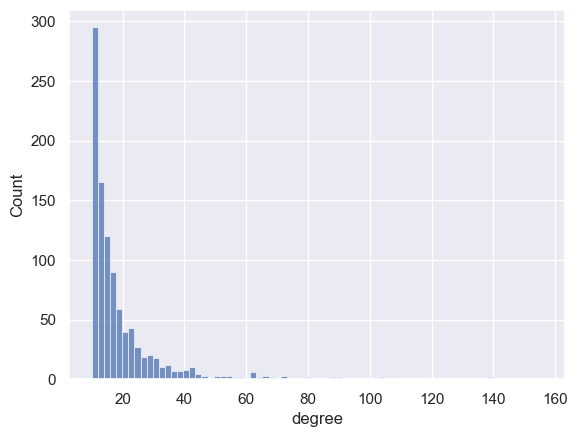

In [8]:
from raphtory import graph_gen

g = Graph()
graph_gen.ba_preferential_attachment(g,vertices_to_add=1000,edges_per_step=10)
view = g.window(0,1000)

ids = []
degrees = []
for v in view.vertices:
    ids.append(v.id)
    degrees.append(v.degree())

df = pd.DataFrame.from_dict({"id":ids,"degree": degrees})

sns.set()
sns.histplot(df.degree)

In [9]:
from raphtory import Graph
from raphtory import algorithms
from raphtory import graph_loader
g = graph_loader.lotr_graph()
views_l1 = g.rolling(1000)

<Axes: xlabel='Time', ylabel='Average Interactions'>

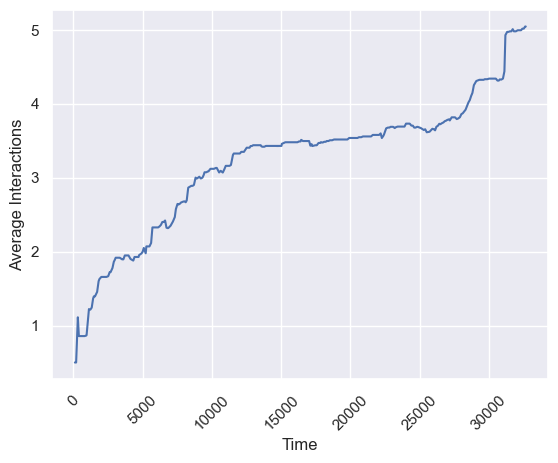

In [10]:
views = g.expanding(100)

timestamps   = []
vertex_count = []
edge_count   = []
degree      = []

for view in views:
    timestamps.append(view.latest_time)
    #vertex_count.append(view.num_vertices())             
    #edge_count.append(view.num_edges())
    degree.append(view.count_edges()/max(1,view.count_vertices()))             
             
sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Average Interactions")
sns.lineplot(x = timestamps, y = degree,ax=ax) 

<Axes: xlabel='Time', ylabel='Interactions'>

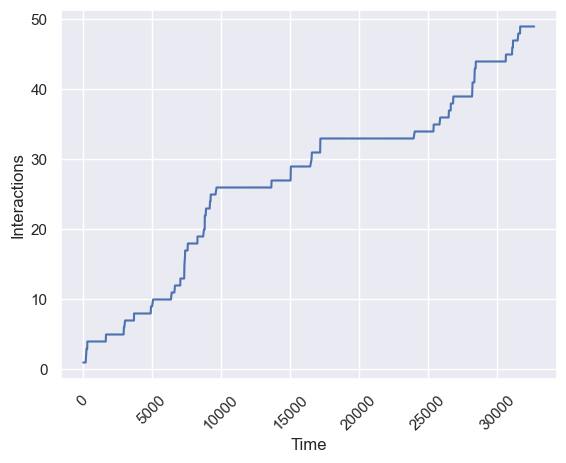

In [11]:
views = g.expanding(step=10)  

timestamps   = []
degree       = []

for view in views:
    timestamps.append(view.latest_time)
    gandalf = view.vertex("Gandalf")
    if(gandalf is not None):
        degree.append(gandalf.degree())
    else:
        degree.append(0)
            
             
sns.set_context()
ax = plt.gca()
plt.xticks(rotation=45)
ax.set_xlabel("Time")
ax.set_ylabel("Interactions")
sns.lineplot(x = timestamps, y = degree,ax=ax) 